<div id="toc"> </div>

# Recommending movies from around the world!
## Motivation
One of the potential dangers in recommender systems is also what they are meant to do- recommend you things that you will continue to like. This can lead people to continue liking things they already like with nothing that would inspire them to try something out of their comfort zone. Branching out can lead to diversity in thinking as well as increased empathy. Therefore, the goal of this project is to deliberately use a user's preference to recommend them movies from another country. The user will be able to choose a country, then the recommender will use their preferences to recommend a movie for them from that country. This project was partly inspired by [Book Riot's list of 80 books from the 80 most populated countries in the world](http://bookriot.com/2016/04/28/around-world-80-books-global-reading-list/ "book riot list").

## Getting the data we need

We'll begin by importing some data. We're going to use the [Movielens](https://grouplens.org/datasets/movielens/) dataset, a dataset of user ratings of movies collected by GroupLens Research at the Department of Computer Science and Engineering at the University of Minnesota. 

This dataset comes with the following files:
* `links.csv`: a list of movie ids, along with their IMDB ids. 
* `movies.csv`: a list of movie ids, their title, and their genre
* `ratings.csv`: a list of user ids, the movie id of the movie they rated, the rating they gave it, and the timestamp of when they rated the movie
* `tags.csv`: a list of user created tags 

Unfortunately, the Movielens data doesn't automatically come with the country associated with each movie. That's okay though- we can write some scripts to grab that data for us. We can do this data gathering using [OMDB](http://www.omdbapi.com/), the Open Movie database, whose API allows us to access IMDB data. Luckily, thanks to `links.csv`, we have the IMDB ids, so accessing the data is easy.

In the code snippet below, we can see the first five rows of `links.csv`. We'll be using [pandas](http://pandas.pydata.org/), a data analysis library, for most of our data manipulation... at first.

In [2]:
# pandas library for data analysis (good read reading in and manipulating our CSV files)
import pandas as pd
# we'll need the requests library to make http requests to the OMDB API
import requests

# open links.csv in order to access IMDB id numbers
links_file = pd.read_csv('movie-lens-data/links.csv', dtype={'imdbId': object, 'tmdbId': object})
links_file.head(n=5)

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


We'll do one example of using the `requests` library to get our data from OMDB next.

In [3]:
# get the OMDB API URL
omdb_url = 'http://www.omdbapi.com/?i=tt'

# get the IMDB id for one of our movies
imdb_id = links_file.iloc[0].imdbId

# get the full OMDB url
url = omdb_url + imdb_id
print 'The OMDB URL we will send our request to: %s' % url

# get the countries associated with the movie
response = requests.get(url)
countries = response.json()['Country']
print 'Country associated with movieId %s: %s' %(links_file.iloc[0].movieId, countries)

The OMDB URL we will send our request to: http://www.omdbapi.com/?i=tt0114709
Country associated with movieId 1: USA


Cool, so we found the first movie listed was a movie from the USA! So what movie was it? Since we only have the movie ID, we'll have to JOIN it with the information in `movies.csv` to get the actual movie title.

In [4]:
movies_file = pd.read_csv('movie-lens-data/movies.csv')
movies_file.head(n=5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Oh cool- Toy Story, most definitely a movie from the US! We can add this to our `movies.csv` file so that it will look like:

In [5]:
movies_file.set_value(0, 'country', countries)
movies_file.head(n=5)

,movieId,title,genres,country
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USA
1,2,Jumanji (1995),Adventure|Children|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


We'll do this for the entire `movies.csv` file. Once we do that, we can take a look at our data.

### Movielens data
Since we're recommending movies by country, we should get a sense of how our data is distributed across countries. I went through the data and got some stats on the countries. Some movies have multiple countries associated with them, marked by 'USA|China|UK', for example, so in these cases I counted the movie as one for each of those countries. 

This non-commercial license of GraphLab Create for academic use is assigned to ajking@bu.edu and will expire on March 26, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1493073791.log


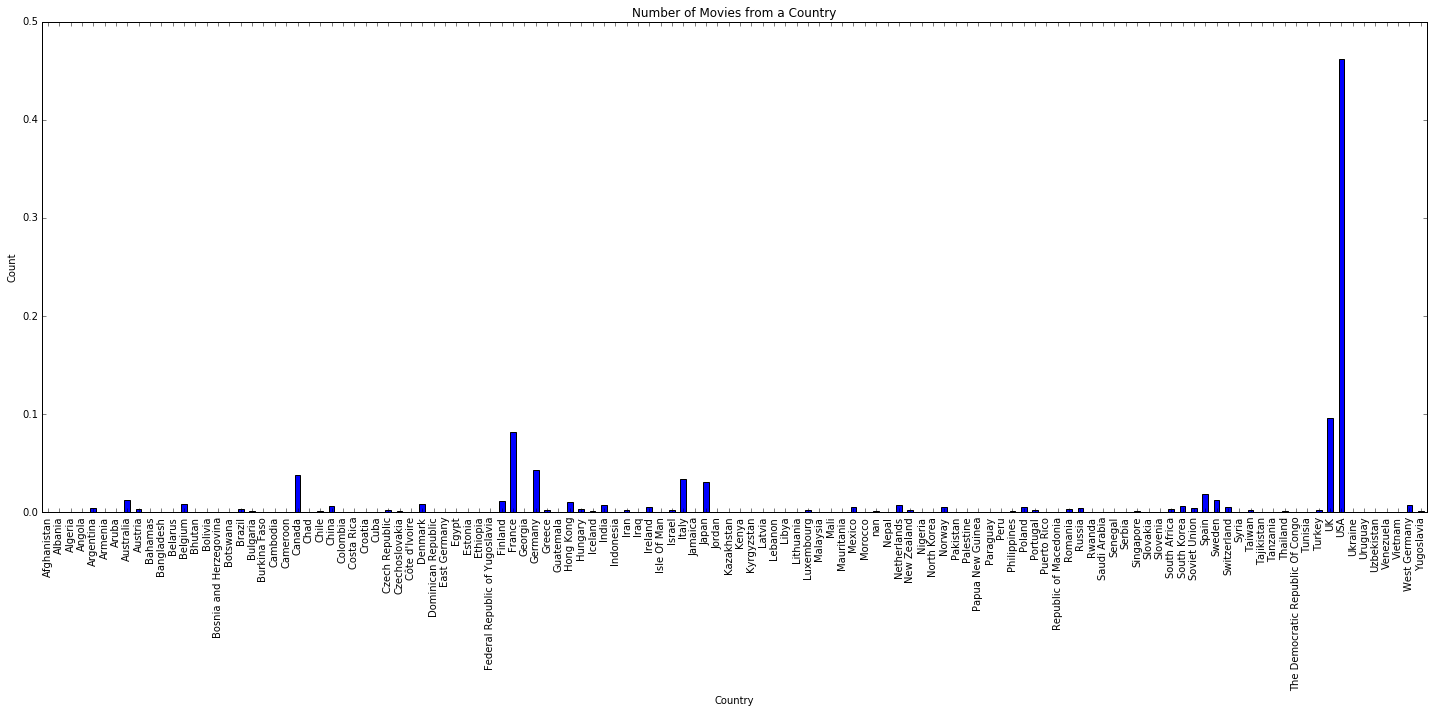

In [6]:
# stuff to make our graph show up in the notebook
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# read in the file I had generated of number of times a country is attributed to a movie
country_stats = pd.read_csv('scripts/output/country-stats-20m.csv')
axes = country_stats.plot(x='country', y='count_percentage', kind='bar', title='Number of Movies from a Country',
                              legend=False)
# set the axes and set display
axes.set_xlabel("Country")
axes.set_ylabel("Count")
plt.tight_layout()
plt.show()

From this plot, it's pretty clear that the Movielens dataset has a huge number of movies from the USA- nearly 50%! After the USA, there are many from the UK, France, and Canada, along with a significant number from Italy, Japan, and Germany. This is important to keep in mind later when we look at what kind of recommendations we get.

## Recommender Types
We're going to try out three different types of recommendation systems:
* Popularity Recommender
* Item Similarity Recommender
* Ranking Factorization Recommender

The following code involves importing the data and splitting it into test and train data. This code will be used for all of the recommender types.


In [7]:
# let's choose a country that we're interested in watching a movie from
country = 'Japan'

# we'll import the ratings.csv which has data in the format of userId, movieId, rating, timestamp
ratings_csv_path = 'movie-lens-data/ratings.csv'
ratings_data = pd.read_csv(ratings_csv_path, encoding='utf-8')
ratings_data.head(n=5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [8]:
# now we need a data frame of the data we just got from OMDB that includes the country data
# this file is of the format movieId, title, genres, country
movies_country_csv_path = 'scripts/output/movie-countries.csv'
movies_data = pd.read_csv(movies_country_csv_path, encoding='utf-8', keep_default_na=False)
movies_data.head(n=5)

,movieId,title,genres,country
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,USA
1,2,Jumanji (1995),Adventure|Children|Fantasy,USA
2,3,Grumpier Old Men (1995),Comedy|Romance,USA
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,USA
4,5,Father of the Bride Part II (1995),Comedy,USA


In [9]:
# import the library that will split our data for us
from sklearn.model_selection import train_test_split

# split 80% training, 20% testing
training_data, test_data = train_test_split(ratings_data, test_size=0.2)
print "number of ratings in training set: %d " % training_data.shape[0]
print "number of ratings in test set: %d " % test_data.shape[0]

number of ratings in training set: 80003 
number of ratings in test set: 20001 


Alright, now we're ready for each recommender type!

### Popularity Recommender
The popularity recommender does not actually use any machine learning- it simply recommends the most popular items based on previous user ratings. In other words, there is no personalization for the current user- all users receive the same results. The Bookbub list of 80 books is an example of a sort of popularity recommender since everybody is exposed to the same recommendations.

In [10]:
# first we will merge our ratings data with our movie/country data
training_ratings_with_movies = pd.merge(training_data, movies_data, on='movieId').sort_values(by=['userId', 'movieId'])
training_ratings_with_movies.head(n=5)

,userId,movieId,rating,timestamp,title,genres,country
33570,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,USA
45625,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,USA
28189,1,1061,3.0,1260759182,Sleepers (1996),Thriller,USA
52902,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,UK|USA
14393,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,Italy|France


In [11]:
# now we can apply a filter for country on the data set. 
country_filter = training_ratings_with_movies[training_ratings_with_movies.apply(
    lambda x: country in x['country'], axis=1)]
print "total number of movies associated with %s: %d" %(country, country_filter.shape[0])
country_filter.head(n=5)

total number of movies associated with Japan: 1758


,userId,movieId,rating,timestamp,title,genres,country
53701,2,273,4.0,835355779,Mary Shelley's Frankenstein (Frankenstein) (1994),Drama|Horror|Sci-Fi,USA|Japan|UK
74113,4,4006,2.0,949982238,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi,USA|Japan
44231,5,5679,4.5,1163374389,"Ring, The (2002)",Horror|Mystery|Thriller,USA|Japan
68339,6,1687,2.0,1109258281,"Jackal, The (1997)",Action|Thriller,USA|UK|France|Germany|Japan
61449,8,7143,3.5,1154400294,"Last Samurai, The (2003)",Action|Adventure|Drama|War,USA|New Zealand|Japan


We can do this country filter multiple ways. This first way takes any movie that has Japan associated with it. This next filter only accepts movies where Japan is the sole attributed country. This may be relevant since it seems that many times when a country is attributed as one among many countries, the movie does not actually have much to do with that country. For instance, A Simple Plan was co-financed by international partners from Germany, UK, France and so have these countries attributed to it. This isn't ideal if our goal is to learn about Japan as a country, so the sole filter may be more useful.

In [12]:
sole_country_filter = training_ratings_with_movies.loc[training_ratings_with_movies['country']==country]
print "total number of movies attributed solely to %s: %d" %(country, sole_country_filter.shape[0])
sole_country_filter.head(n=5)

total number of movies attributed solely to Japan: 659


,userId,movieId,rating,timestamp,title,genres,country
75448,12,3799,1.0,968045198,Pokémon the Movie 2000 (2000),Animation|Children,Japan
69022,12,3864,3.0,968045015,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),Action|Adventure|Sci-Fi,Japan
35907,15,2019,4.5,1134521638,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,Japan
55812,15,2905,4.0,1040205754,Sanjuro (Tsubaki Sanjûrô) (1962),Action|Adventure|Drama,Japan
55171,15,3000,4.0,997939086,Princess Mononoke (Mononoke-hime) (1997),Action|Adventure|Animation|Drama|Fantasy,Japan


Okay, now the fun part- let's see what the most popular movies are from Japan.

In [13]:
import numpy as np

popular_movies = sole_country_filter.groupby('title').agg({'rating': [np.size, np.mean]}).sort_values(
    [('rating', 'mean')], ascending=False).reset_index()
popular_movies.head(n=5)

title rating     
                                                       size mean
0                            Kwaidan (Kaidan) (1964)    1.0  5.0
1                                   Wild Zero (2000)    1.0  5.0
2  Neon Genesis Evangelion: The End of Evangelion...    1.0  5.0
3                One Piece Film: Strong World (2009)    1.0  5.0
4                  Ugetsu (Ugetsu monogatari) (1953)    1.0  5.0

This isn't ideal- these movies that have only one rating are getting really high ratings since one person gave them a five star. That's hardly what popular means! We could apply some sort of algorithm in order to get a better 'popularity' score. The function below is adapted from [Evan Miller's post](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html) on how to get a more accurate rating. 

In [14]:
import math

def wilson_score(num_positive_ratings, num_ratings):
    # we'll default to a 95% confidence level
    if num_ratings == 0:
        return 0
    # this is a z score, since we're using a 95% confidence level, z will always be 1.96
    z = 1.96
    phat = 1.0 * num_positive_ratings / num_ratings
    return (phat + z*z/(2*num_ratings) - z * 
            math.sqrt((phat*(1-phat)+z*z/(4*num_ratings))/num_ratings))/(1+z*z/num_ratings)
    
wilson_score(80, 100)

0.7111690380734976

In [15]:
# here's a function to help us determine what a 'positive' rating is
def number_positive_ratings(x):
    pos = x[x >= 3]
    return pos.size
    
# make our data frame show us the number of positive ratings, as well as number overall ratings 
# grouped by movie title    
grouped_ratings = sole_country_filter.groupby('title').agg({
        'rating': [number_positive_ratings, np.size]}).reset_index()

# apply the wilson score function now that we have number of positive ratings and number of overall ratings
grouped_ratings['wilson score'] = np.vectorize(wilson_score)(grouped_ratings['rating']['number_positive_ratings'], 
                                                             grouped_ratings['rating']['size'])

# let's see what's popular in Japan!
grouped_ratings[['title','wilson score']].sort_values('wilson score', ascending=False).head(n=5)


,title,wilson score
,,
70,Howl's Moving Castle (Hauru no ugoku shiro) (2...,0.845356
128,Seven Samurai (Shichinin no samurai) (1954),0.838607
113,Princess Mononoke (Mononoke-hime) (1997),0.798525
54,Ghost in the Shell (Kôkaku kidôtai) (1995),0.790084
132,Spirited Away (Sen to Chihiro no kamikakushi) ...,0.786395


Nice- this list of movies looks a lot more reasonable. The Wilson Score tells us how confident we are that ratings for this movie is positive. Movies 2-5 in this list are all highly acclaimed Miyazaki movies which even I've heard of before. I had never heard of Seven Samurai, but the [Seven Samurai Wikipedia](https://en.wikipedia.org/wiki/Seven_Samurai) page says:
> Since its release, Seven Samurai has consistently ranked highly in critics' lists of the greatest films, such as the BFI's Sight & Sound and Rotten Tomatoes polls. It has remained highly influential, often seen as one of the most "remade, reworked, referenced" films in cinema.

So it seems like we are indeed getting popular movies back!

### Item Similary Recommender
Alright, let's move on and try to get some personalization with our recommendations. The next method we are going to use is the Item Similarity Recommender. What this means is that you tell the model the movies you like, and the model will go and try to find the movies that are the most similar to the ones that you liked and return them to you.

To create the model, we take in our user ratings file. The model will compute the similarity between movies by associating movies that a user has watched before and enjoyed as similar. The similarity function is often a Cosine or Pearson similarity function.

I implemented this using the libraries we have already been using, but building the model proved pretty memory intensive on my computer, even with Movielens's smaller dataset. If you're interested, the code can be found in my github and was based largely off of [Ethan Rosenthal's blog](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/). 

I decided to look into other libraries that would be more powerful and efficient and came across [Graphlab](https://turi.com/). Graphlab is particularly good for large data sets that need efficient distributed and parallel algorithms- sounds perfect for our needs! It also makes model creation very easy and on a high level, similar to what you might see from Microsoft Azure but without the UI.

In [22]:
%%capture
import graphlab as gl

# Graphlab uses SFrames instead of Pandas data frames, but the conversion is easy.
# we have training_data as a pandas dframe so...
training_data_gl = gl.SFrame(training_data)

# making a model in graphlab is as easy as...
item_similarity_recommender = gl.item_similarity_recommender.create(training_data_gl, user_id='userId', 
                                                                    item_id='movieId', target='rating', 
                                                                    similarity_type='cosine')

# and making recommendations...
#recommendations = model.recommend(users=[1], k=num_movies).join(movies_data)